In [10]:
from nn import io
from nn import nn, preprocess


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:


rap1 = io.read_text_file('data/rap1-lieb-positives.txt')

In [3]:

yeast = io.read_fasta_file('data/yeast-upstream-1k-negative.fa')

# process yeast data to same length by just breaking it up into 17 bp chunks


In [4]:
neg_seqs = []
for seq in yeast:
    for i in range(0, len(seq), 17):
        if i+17 > len(seq):
            i = len(seq)-17
        neg_seqs.append(seq[i:i+17])

In [5]:
len(neg_seqs)

186459

In [6]:
len(rap1)

137

# we balance the datasets by oversampling the positive exampels and downsampling the neg examples

In [11]:

rap1 = preprocess.one_hot_encode_seqs(rap1)
neg_seqs = preprocess.one_hot_encode_seqs(neg_seqs)

In [13]:
# 0 is negative
# 1 is positive
labels = [0]*len(neg_seqs) + [1] * len(rap1)
seqs = neg_seqs + rap1

x, y = preprocess.sample_seqs(seqs, labels)
x = x.astype(int)
y = y.astype(int)

In [14]:
arch = [{'input_dim': 68, 'output_dim': 32, 'activation': ''},  {'input_dim':32, 'output_dim': 1, 'activation': ''}]

lrs = [0.01, 0.001]
acts = [['sigmoid', 'sigmoid'],
       ['relu', 'relu'],
      ]
batch_sizes = [2048, 4096]




In [15]:
seed = 0
epochs = 50
loss_function = 'bce'

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.1)


In [17]:
y_test.shape

(18660,)

In [ ]:
# lets do a hyperparameter sweep to find the optimial params

In [20]:
hyperparms_train = {}
hyperparms_val = {}
mses = {}

for lr in lrs:
    for batch_size in batch_sizes:
        for act in acts:
            print(lr)
            arch[0]['activation'] = act[0]
            arch[1]['activation'] = act[1]
#             arch[2]['activation'] = act[2]
#             arch[3]['activation'] = act[3]            
            mynn = nn.NeuralNetwork(nn_arch = arch, 
                               lr = lr, 
                               seed = seed, 
                               batch_size=batch_size, 
                               epochs=epochs, 
                               loss_function=loss_function)
            train_l, val_l = mynn.fit(X_train, y_train, X_test, y_test)
            mse = mynn.predict(X_test)
            params = f'{lr}_{batch_size}_{act[0]}+{act[1]}'
            mses[params] = mse
            hyperparms_train[params] = train_l
            hyperparms_val[params] = val_l
            

0.01
0.01
0.01
0.01
0.001
0.001
0.001
0.001


In [22]:
import numpy as np
min_val = {}
curr_min = 100000
curr_min_params = ''
for k,v in hyperparms_val.items():
    val = np.min(v)
    min_val[k] = val
    if val < curr_min:
        curr_min = val
        curr_min_params=k

lr, batch_size, arch = curr_min_params.split('_')
l1, l2 = arch.split('+')

print(f"Best hyper params to use is: lr: {lr}, batch_size: {batch_size}, l1 activation: {l1}, l2 activation: {l2}")
print('This results in a validation loss of: ', curr_min)
print('This model has an MSE of: ', np.mean(mses[curr_min_params][-1]))
      


Best hyper params to use is: lr: 0.01, batch_size: 4096, l1 activation: relu, l2 activation: relu
This results in a validation loss of:  -4.566812762060107
This model has an MSE of:  0.0


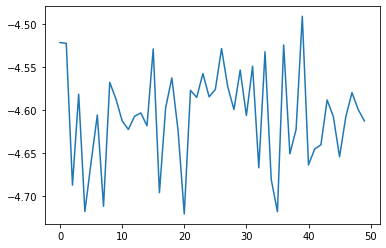

In [23]:
plt.plot(range(epochs),hyperparms_train[curr_min_params])

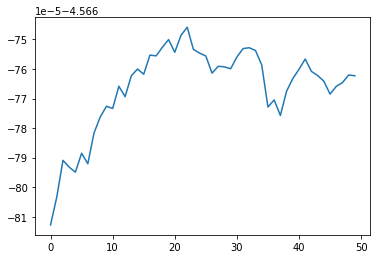

In [24]:
plt.plot(range(epochs),hyperparms_val[curr_min_params])

In [25]:
# for this example, I used the binary cross entropy loss 
# something is wrong with my BCE backprop though, since the the loss is increasing....